# Sensorless Drive Diagnosis

> In this example, the main focus is the classification of individual states of a motor.

In [ ]:
# |hide
from nbdev.showdoc import *

In [ ]:
# | hide
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import copy

from sklearn.metrics import classification_report
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns

from mlmvn.layers import FirstLayer, HiddenLayer, OutputLayer, cmplx_phase_activation
from mlmvn.loss import ComplexMSELoss
from mlmvn.optim import MySGD, ECL
from pathlib import Path
from clearml import Task, Logger

In [ ]:
# | hide
# --- helper functions ---
def reverse_one_hot(x, neuronCats):
    a = np.zeros(len(x))
    x = torch.detach(x)
    for i in range(len(x)):
        a[i] = torch.max(x[i]) - 1 + np.argmax(x[i]) * neuronCats
    return a


def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)


def prepare_data(x_train, x_valid, y_train, y_valid, neuronCats):
    # one-hot encoding
    numSamples, numFeatures = x_valid.shape
    y_valid_int = y_valid
    y2 = y_valid + 1  # auxiliary variable so that classes start at 1 and not 0
    numClasses = max(y2)
    target_ids = range(numClasses)
    no = int(np.ceil(numClasses / neuronCats))  # number of output neurons
    if no != 1:
        y_valid = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_valid[i, k] = c
    numSamples, numFeatures = x_train.shape
    y_train_int = y_train
    y2 = y_train + 1  # auxiliary variable so that classes start at 1 and not 0
    if no != 1:
        y_train = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_train[i, k] = c
    del y2

    # Convert numpy arrays into torch tensors
    x_train, y_train, x_valid, y_valid = map(
        torch.tensor, (x_train, y_train, x_valid, y_valid)
    )
    if y_train.size().__len__() == 1:
        y_train = torch.unsqueeze(y_train, 1)
        y_valid = torch.unsqueeze(y_valid, 1)

    # convert angles to complex numbers on unit-circle
    x_train = torch.exp(1.0j * x_train)
    x_valid = torch.exp(1.0j * x_valid)

    return x_train, x_valid, y_train, y_valid


def get_splitted_data(X, y, neuronCats):
    x_train, x_valid, y_train, y_valid = train_test_split(
        X, y, train_size=46806, random_state=42
    )
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )

    return x_train, x_valid, y_train, y_valid


def get_splitted_data_by_index(X, y, neuronCats, train_index, test_index):
    x_train, x_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )
    return x_train, x_valid, y_train, y_valid


# --- Plots ---
def plot_loss(title, losses, scores):
    plt.rcParams["axes.grid"] = True
    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.legend(["Acc", "Loss"])

    plt.show()


def plot_weights(title, ylabel_1, ylabel_2, weights_real, weights_imag):
    # y_min = np.min([np.min(weights_real), np.min(weights_imag)])
    # y_max = np.max([np.max(weights_real), np.max(weights_imag)])

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 3))
    fig.suptitle(title)
    ax[0].plot(np.linspace(1, len(weights_real), len(weights_real)), weights_real)
    ax[0].set_xlabel("Step")
    ax[0].set_ylabel(ylabel_1)
    # ax[0].set_title("Real Valued Weigts")
    ax[0].set_xlim(0, len(weights_real))
    # ax[0].set_ylim(y_min, y_max)

    ax[1].plot(np.linspace(1, len(weights_imag), len(weights_imag)), weights_imag)
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel(ylabel_2)
    # ax[1].set_title("Imaginary Valued Weights")
    ax[1].set_xlim(0, len(weights_imag))
    # ax[1].set_ylim(y_min, y_max)

    plt.show()


def plot_loss_acc_list(title, list_losses, list_scores, image_name):
    losses = np.mean(list_losses, axis=0)
    scores = np.mean(list_scores, axis=0)

    losses_std = np.std(list_losses, axis=0)
    scores_std = np.std(list_scores, axis=0)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 3))
    fig.suptitle(title)
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.fill_between(
        np.linspace(1, len(losses), len(losses)),
        losses + losses_std,
        losses - losses_std,
        alpha=0.5,
        linewidth=0,
    )

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.fill_between(
        np.linspace(1, len(scores), len(scores)),
        scores + scores_std,
        scores - scores_std,
        alpha=0.5,
        linewidth=0,
    )
    ax1.set_xlabel("Epoch")

    plt.legend(["Loss Mean", "Loss Std", "Acc. Mean", "Acc. Std"])
    plt.grid(visible=True)
    fig.savefig(image_name, format="png", dpi=600)

    plt.show()
    # save
    # fig.savefig(image_name + ".svg", format="svg", dpi=600)


# --- Logging ---
model_dict: dict = {}


def fc_hook(layer_name, module, grad_input, grad_output):
    if layer_name in model_dict:
        model_dict[layer_name]["weights"] = module.weights.detach().clone()
        model_dict[layer_name]["bias"] = module.bias.detach().clone()
        model_dict[layer_name]["grad_input"] = grad_input
        model_dict[layer_name]["grad_output"] = grad_output
    else:
        model_dict[layer_name] = {}
        model_dict[layer_name]["weights"] = module.weights.detach().clone()
        model_dict[layer_name]["bias"] = module.bias.detach().clone()
        model_dict[layer_name]["grad_input"] = grad_input
        model_dict[layer_name]["grad_output"] = grad_output

In [ ]:
# | hide
# control variables
# number of categories a neuron can distinguish / parameter that determines the number of output neurons
neuronCats = 1
# number of categories per neuron, i.e. neuronCats (+ 1 for others in case of multiple Outputs)
categories = 2
# how often a classification sector occurs (1 means no periodicity)
periodicity = 1
# path to store best model parameters

## Load Data

In [ ]:
train_csv = pd.read_csv(
    "data/autass_data2.csv",
    header=None,
    dtype=np.double,
)
data = np.array(train_csv.values[:, 1:50])
del train_csv

In [ ]:
X = data[:, 0:48]
y = data[:, 48].astype(int) - 1

yt = copy.copy(y)
yt[yt == 0] = 20
yt[yt == 1] = 21
yt[yt == 2] = 22
yt[yt == 3] = 23
yt[yt == 4] = 26
yt[yt == 5] = 24
yt[yt == 6] = 27
yt[yt == 7] = 29
yt[yt == 8] = 30
yt[yt == 9] = 25
yt[yt == 10] = 28
yt -= 20
y = yt
del yt

## Config

In [ ]:
epochs = 200
batch_size = 538
lr = 1

## Single Layer

### MLMVN [48-10-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-10-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 10)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(10, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-10-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-10-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=6bcfc0d4690e42f4a3cbe67fce6889b9
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/6bcfc0d4690e42f4a3cbe67fce6889b9/output/log


{'learning_rate': 1,
 'epochs': 5,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-10-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_932/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 10:07:23,675 - clearml.frameworks - INFO - Found existing registered model id=caa96da5a415490ca1ea0f95b383f403 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-10-11.pt] reusing it.
Train Acc.:  0.7186745572243468
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1063
           1       0.89      0.64      0.75      1064
           2       0.90      0.74      0.81      1064
           3       0.91      0.81      0.86      1064
           4       0.76      0.62      0.68      1064
           5       0.72      0.90      0.80      1063
           6       0.68      0.73      0.70      1064
           7       0.97      0.96      0.97      1064
           8       0.99      0.99      0.99      1064
           9       0.77      0.77      0.77      1064
          10       0.87      0.69      0.77      1064

   micro avg       0.84      0.80      0.82     11702
   macro avg       0.85      0.80      0.

/tmp/ipykernel_932/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train Acc.:  0.7787296771850364
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1063
           1       0.89      0.59      0.71      1064
           2       0.94      0.87      0.90      1064
           3       0.92      0.86      0.89      1063
           4       0.77      0.76      0.76      1064
           5       0.79      0.82      0.81      1064
           6       0.72      0.83      0.77      1064
           7       0.99      0.96      0.98      1064
           8       1.00      0.95      0.97      1064
           9       0.86      0.86      0.86      1064
          10       0.84      0.78      0.81      1064

   micro avg       0.88      0.83      0.85     11702
   macro avg       0.88      0.83      0.85     11702
weighted avg       0.88      0.83      0.85     11702
 samples avg       0.80      0.83      0.81     11702



/tmp/ipykernel_932/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train Acc.:  0.7650992372935672
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1064
           1       0.90      0.58      0.70      1064
           2       0.95      0.84      0.89      1064
           3       0.90      0.79      0.84      1063
           4       0.87      0.59      0.71      1064
           5       0.80      0.83      0.82      1064
           6       0.78      0.70      0.74      1063
           7       0.98      0.93      0.96      1064
           8       1.00      0.97      0.98      1064
           9       0.82      0.85      0.83      1064
          10       0.94      0.72      0.81      1064

   micro avg       0.89      0.79      0.84     11702
   macro avg       0.89      0.79      0.83     11702
weighted avg       0.89      0.79      0.83     11702
 samples avg       0.78      0.79      0.78     11702



/tmp/ipykernel_932/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train Acc.:  0.678146431089367
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1063
           1       0.81      0.18      0.29      1064
           2       0.82      0.64      0.72      1064
           3       0.94      0.83      0.88      1063
           4       0.72      0.59      0.65      1064
           5       0.77      0.82      0.79      1064
           6       0.94      0.30      0.46      1064
           7       0.97      0.99      0.98      1064
           8       0.97      0.92      0.95      1064
           9       0.68      0.96      0.80      1064
          10       0.81      0.70      0.75      1064

   micro avg       0.83      0.72      0.77     11702
   macro avg       0.84      0.72      0.74     11702
weighted avg       0.84      0.72      0.74     11702
 samples avg       0.69      0.72      0.70     11702



/tmp/ipykernel_932/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train Acc.:  0.6857521310915035
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1064
           1       0.90      0.08      0.14      1064
           2       0.75      0.85      0.80      1064
           3       0.93      0.80      0.86      1064
           4       0.77      0.55      0.64      1064
           5       0.53      0.92      0.68      1064
           6       0.78      0.58      0.67      1063
           7       0.98      0.97      0.98      1064
           8       0.98      0.85      0.91      1063
           9       0.84      0.82      0.83      1064
          10       0.74      0.77      0.75      1064

   micro avg       0.80      0.73      0.77     11702
   macro avg       0.83      0.73      0.74     11702
weighted avg       0.83      0.73      0.74     11702
 samples avg       0.71      0.73      0.72     11702



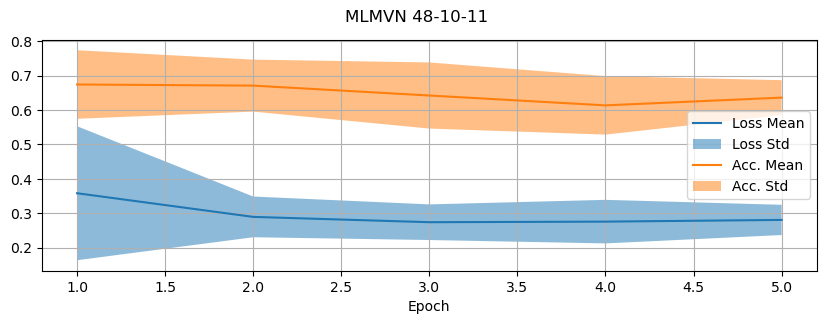

In [ ]:
title = "MLMVN 48-10-11"
image_name = "results/MLMVN_48-10-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-20-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-20-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 20)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(20, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-20-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-20-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=2937a1c5c09247d3afefe736b93cce93
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/2937a1c5c09247d3afefe736b93cce93/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-20-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 08:33:02,557 - clearml.frameworks - INFO - Found existing registered model id=c337b94a22444d809d449783726d8ee2 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-20-11.pt] reusing it.
Epoch 9 loss is 0.1781452279297529
Epoch 19 loss is 0.17121365507481565
Epoch 29 loss is 0.23437533994636411
Epoch 39 loss is 0.249442526042442
Epoch 49 loss is 0.2709493982290144
Epoch 59 loss is 0.22188192248227645
Epoch 69 loss is 0.24606682756213247
Epoch 79 loss is 0.291044741861424
Epoch 89 loss is 0.24921788018106592
Epoch 99 loss is 0.24654104628164147
Epoch 109 loss is 0.2149965350030757
Epoch 119 loss is 0.20888710558226523
Epoch 129 loss is 0.18029340312631476
Epoch 139 loss is 0.21206527705421888
Epoch 149 loss is 0.16859814960066902
Epoch 159 loss is 0.20565043305802141
Epoch 169 loss is 0.20745351853536964
Epoch 179 loss is 0.21776656653704443
Epoch 189 loss is 0.20066393883063724
Epoch 199 loss is 0.17997682184925615
Train Acc.:  0.8812759047985301
Val

In [ ]:
title = "MLMVN 48-20-11"
image_name = "results/MLMVN_48-20-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-50-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-50-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 50)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(50, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-50-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-50-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=b9c663cb49f645d3b526ff62b971b678
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/b9c663cb49f645d3b526ff62b971b678/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-50-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 08:36:28,294 - clearml.frameworks - INFO - Found existing registered model id=bb96e63090904339bf87c4852d30bdb6 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-50-11.pt] reusing it.
Epoch 9 loss is 0.12631168614962632
Epoch 19 loss is 0.08741677563113538
Epoch 29 loss is 0.07765135114449577
Epoch 39 loss is 0.07199543979859238
Epoch 49 loss is 0.05459176181501563
Epoch 59 loss is 0.054154946830923104
Epoch 69 loss is 0.0498279498984762
Epoch 79 loss is 0.04969739252919254
Epoch 89 loss is 0.05646039586774165
Epoch 99 loss is 0.05206559631806764
Epoch 109 loss is 0.04809522582296451
Epoch 119 loss is 0.0522341919664429
Epoch 129 loss is 0.0495262401204281
Epoch 139 loss is 0.04954010092306082
Epoch 149 loss is 0.061976915229967955
Epoch 159 loss is 0.05182441637727222
Epoch 169 loss is 0.05091017378293241
Epoch 179 loss is 0.0561740020607465
Epoch 189 loss is 0.06101975489402404
Epoch 199 loss is 0.06845130197965535
Train Acc.:  0.961970687518694

In [ ]:
title = "MLMVN 48-50-11"
image_name = "results/MLMVN_48-50-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-100-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-100-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-100-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-100-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=77bda608f5dd4cbf9fb5bf146c9bcdbe
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/77bda608f5dd4cbf9fb5bf146c9bcdbe/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-100-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 08:40:51,411 - clearml.frameworks - INFO - Found existing registered model id=0f73e6db01fc42988672e4f44c0add5f [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-100-11.pt] reusing it.
Epoch 9 loss is 0.09760215896283031
Epoch 19 loss is 0.07483332226588477
Epoch 29 loss is 0.06169817582724667
Epoch 39 loss is 0.04806632873441776
Epoch 49 loss is 0.050257943968239405
Epoch 59 loss is 0.045243461048822334
Epoch 69 loss is 0.03916302966121763
Epoch 79 loss is 0.03600947264373011
Epoch 89 loss is 0.0327954003325785
Epoch 99 loss is 0.034495561806988345
Epoch 109 loss is 0.02976081583721455
Epoch 119 loss is 0.03207888606505858
Epoch 129 loss is 0.029421696533450108
Epoch 139 loss is 0.02886477329200674
Epoch 149 loss is 0.028011108627125445
Epoch 159 loss is 0.02746762018733399
Epoch 169 loss is 0.029159449466333746
Epoch 179 loss is 0.028677871059498893
Epoch 189 loss is 0.026269004340911915
Epoch 199 loss is 0.02659348237350445
Train Acc.:  0.98207

In [ ]:
title = "MLMVN 48-100-11"
image_name = "results/MLMVN_48-100-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

## Multi Layer

### MLMVN [48-10-10-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-10-10-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 10)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(10, 10)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(10, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-10-10-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-10-10-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=7aa1a5aeeab040fda27730a9cb90d8ad
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/7aa1a5aeeab040fda27730a9cb90d8ad/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-10-10-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.6741966148101034
Epoch 19 loss is 0.6345819678996693
Epoch 29 loss is 0.6163333298521995
Epoch 39 loss is 0.5973288617286425
Epoch 49 loss is 0.5657958380010314
Epoch 59 loss is 0.5930215843207252
Epoch 69 loss is 0.614107440452483
Epoch 79 loss is 0.6680024372385054
Epoch 89 loss is 0.670419685702236
Epoch 99 loss is 0.6396620484680041
Epoch 109 loss is 0.7318713292921706
Epoch 119 loss is 0.7326499528623525
Epoch 129 loss is 0.7676124397701742
Epoch 139 loss is 0.7363896056980302
Epoch 149 loss is 0.7518392231032288
Epoch 159 loss is 0.6876373192278051
Epoch 169 loss is 0.684599693905956
Epoch 179 loss is 0.6865932359686486
Epoch 189 loss is 0.6739611875627026
Epoch 199 loss is 0.6541066273988838
Train Acc.:  0.3464940392257403
Val Acc.:  0.3492266940100829
              precision    recall  f1-score   support

           0       0.56      0.70      0.63      1074
           1       0.59      0.43      0.50      1089
           2       0.59      0.23      0.33      

In [ ]:
title = "MLMVN 48-10-10-11"
image_name = "results/MLMVN_48-10-10-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-20-20-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-20-20-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 20)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(20, 20)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(20, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-20-20-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-20-20-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=63f6d3900d26435baf5c0451ee2550cf
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/63f6d3900d26435baf5c0451ee2550cf/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-20-20-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.4918386432669506
Epoch 19 loss is 0.5658443724932558
Epoch 29 loss is 0.547344653493303
Epoch 39 loss is 0.5003598398694803
Epoch 49 loss is 0.45764246002628084
Epoch 59 loss is 0.48134115218311874
Epoch 69 loss is 0.46767609185504994
Epoch 79 loss is 0.47236872848369066
Epoch 89 loss is 0.45542004995148055
Epoch 99 loss is 0.4707600822371793
Epoch 109 loss is 0.4592737186466213
Epoch 119 loss is 0.44952235101712684
Epoch 129 loss is 0.4279650487928361
Epoch 139 loss is 0.4390951851709622
Epoch 149 loss is 0.4078203854663746
Epoch 159 loss is 0.4626180199815107
Epoch 169 loss is 0.4595541584940826
Epoch 179 loss is 0.41118996909517436
Epoch 189 loss is 0.4143808650128177
Epoch 199 loss is 0.42120076453410465
Train Acc.:  0.6030850745630902
Val Acc.:  0.6048876356489788
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1074
           1       0.71      0.70      0.71      1089
           2       0.79      0.67      

In [ ]:
title = "MLMVN 48-20-20-11"
image_name = "results/MLMVN_48-20-20-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-50-50-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-50-50-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 50)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(50, 50)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(50, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-50-50-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-50-50-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=3ec0ba0e69fe4e8781f1f56f68bb4df0
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/3ec0ba0e69fe4e8781f1f56f68bb4df0/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-50-50-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.17595385331554345
Epoch 19 loss is 0.24443298597993288
Epoch 29 loss is 0.34861398016646006
Epoch 39 loss is 0.35088833894092397
Epoch 49 loss is 0.3184690939966281
Epoch 59 loss is 0.29159015152507245
Epoch 69 loss is 0.29664844727356443
Epoch 79 loss is 0.3148698996217653
Epoch 89 loss is 0.34718880768462584
Epoch 99 loss is 0.32786482129724753
Epoch 109 loss is 0.3249049482370644
Epoch 119 loss is 0.31320303291619195
Epoch 129 loss is 0.30243110019968583
Epoch 139 loss is 0.30238450965742614
Epoch 149 loss is 0.29449084419928934
Epoch 159 loss is 0.2935125197293862
Epoch 169 loss is 0.2872804696457938
Epoch 179 loss is 0.29204265563094745
Epoch 189 loss is 0.3058525140885775
Epoch 199 loss is 0.30025929403593016
Train Acc.:  0.827223005597573
Val Acc.:  0.820986071947364
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1074
           1       0.87      0.82      0.84      1089
           2       0.94      0.90 

In [ ]:
title = "MLMVN 48-50-50-11"
image_name = "results/MLMVN_48-50-50-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-100-100-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-100-100-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(100, 100)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-100-100-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-100-100-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=d2c79e60ea7040fd879fc5e297a36346
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/d2c79e60ea7040fd879fc5e297a36346/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-100-100-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_9096/3249266730.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.14845134117007924
Epoch 19 loss is 0.1329600740131187
Epoch 29 loss is 0.1297421221557918
Epoch 39 loss is 0.11658710957349895
Epoch 49 loss is 0.1263711960559784
Epoch 59 loss is 0.15283946197204235
Epoch 69 loss is 0.20268996749466878
Epoch 79 loss is 0.26901874406663706
Epoch 89 loss is 0.3079409409709422
Epoch 99 loss is 0.28158223191896325
Epoch 109 loss is 0.27721301741939225
Epoch 119 loss is 0.23720462062688716
Epoch 129 loss is 0.23388674674232188
Epoch 139 loss is 0.22834769155604162
Epoch 149 loss is 0.22821928822954132
Epoch 159 loss is 0.1975671042738866
Epoch 169 loss is 0.18680390982844616
Epoch 179 loss is 0.18587410530287377
Epoch 189 loss is 0.19314962951484493
Epoch 199 loss is 0.1799970473113
Train Acc.:  0.888774943383327
Val Acc.:  0.8714859437751004
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1074
           1       0.92      0.88      0.90      1089
           2       0.97      0.91   

In [ ]:
title = "MLMVN 48-100-100-11"
image_name = "results/MLMVN_48-100-100-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()